Votre mission est d’aider les équipes d’Olist à comprendre les différents types d'utilisateurs. Vous utiliserez donc des méthodes non supervisées pour regrouper ensemble des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe marketing pour mieux communiquer.

Votre client, Olist, a spécifié sa demande ainsi :
* La segmentation proposée doit être exploitable et facile d’utilisation pour l’équipe marketing.
* Vous évaluerez la fréquence à laquelle la segmentation doit être mise à jour, afin de pouvoir effectuer un devis de contrat de maintenance.
* Le code fourni doit respecter la convention PEP8, pour être utilisable par Olist.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
pd.set_option('display.max_columns', None)
from sklearn import preprocessing
from sklearn import decomposition
import plotly
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding
from scipy.stats import mannwhitneyu


In [2]:
def distance_IQ(dt, q1=0.25, q3=0.75):
    """
    Compute interquantile value and return number
    of elements 
        * Above Q3 + 1.5*IQ
        * Bellow Q1 - 1*5 IQ
    Arguments:
        _dt: dataFrame (pandas)
        _q1: first quantile (default 0.25)
        _q3: third quantile (default 0.75)
    """
    q1 = dt.quantile(q1)
    q3 = dt.quantile(q3)
    IQ = q3-q1
    count = dt[dt < q1 - 1.5* IQ ].count() 
    print("Element {0} bellow Q1 - 1.5 * IQ ({1:.2f})".format(count, q1 - 1.5* IQ))
    count = dt[dt > q3 + 1.5* IQ ].count() 
    print("Element {0} above Q3 + 1.5 * IQ ({1:.2f})".format(count ,q3 + 1.5 * IQ))

In [3]:
def compare_time(timeSerie, referenceTime = None):
    """
    Difference between 2 time series
    Return 
        time series (days)
    """
    if referenceTime is None:
        referenceTime = pd.Timestamp.today()
    return referenceTime - timeSerie 

In [4]:
def scatter_plot(dt, label1, label2, title, path = None):
    x = dt.loc[:,label1].to_numpy()
    y = dt.loc[:,label2].to_numpy()
    sns.jointplot(data=dt, x = label1, y= label2,  marker="+", s=100, marginal_kws=dict(bins=60))
    #sns.jointplot(data=dt, x = label1, y= label2, kind="kde")
    plt.title(title, size = 20)
    if path is not None:
        plt.savefig(path)
    #ax.legend(loc='best')
    plt.show()

In [5]:
def rootline_mannwhitneyu(X1, X2, alpha = 0.05):
    """
    Non parametric test. Compare two distribution
    Hypothesis:
        H0: Sample distribution are equal
        H1: Sample distribution are not equal
    Arguments:
        X1: first sample (1D array)
        X2: second sample (1D array)
        alpha: risk (to reject or no H0)
    """
    stat, p = mannwhitneyu(X1, X2)
    print('Statistics={0:.3f}, p={1}'.format(stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distribution (reject H0)')




# Importation des données

In [6]:
#on spécifie les colonnes qui correspodnent à des dates
df = pd.read_csv("achat_data.csv", infer_datetime_format = True, parse_dates = [6,7])
df = df.dropna(axis=0)
df.dtypes

customer_id                              object
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                            object
customer_state                           object
order_id                                 object
order_purchase_timestamp         datetime64[ns]
order_delivered_customer_date    datetime64[ns]
price                                   float64
freight_proportion_price                float64
payment_installments                    float64
payment_value                           float64
boleto                                  float64
credit_card                             float64
debit_card                              float64
not_defined                             float64
voucher                                 float64
weight                                  float64
quantity                                float64
review_score                            float64
dtype: object

In [7]:
df.describe()

,customer_zip_code_prefix,price,freight_proportion_price,payment_installments,payment_value,boleto,credit_card,debit_card,not_defined,voucher,weight,quantity,review_score
count,96475.000000,96475.000000,96475.000000,96475.000000,96475.000000,96475.000000,96475.000000,96475.000000,96475.0,96475.000000,96475.000000,96475.000000,96475.000000
mean,35199.179912,137.038198,0.288172,2.912126,157.211337,0.198922,0.758017,0.015377,0.0,0.027684,2386.390267,1.142006,4.142598
std,29839.686571,209.048174,0.298835,2.697252,216.159426,0.399191,0.421896,0.123037,0.0,0.146586,4769.702643,0.538969,1.295325
min,1003.000000,0.850000,0.000000,0.000000,1.737500,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000
25%,11355.000000,45.900000,0.119953,1.000000,60.100000,0.000000,0.500000,0.000000,0.0,0.000000,300.000000,1.000000,4.000000
50%,24436.000000,86.500000,0.205396,2.000000,103.140000,0.000000,1.000000,0.000000,0.0,0.000000,750.000000,1.000000,5.000000
75%,59056.000000,149.900000,0.353797,4.000000,174.330000,0.000000,1.000000,0.000000,0.0,0.000000,2050.000000,1.000000,5.000000
max,99980.000000,13440.000000,21.447059,24.000000,13664.080000,1.000000,1.000000,1.000000,0.0,1.000000,184400.000000,21.000000,5.000000


In [8]:
df.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_purchase_timestamp,order_delivered_customer_date,price,freight_proportion_price,payment_installments,payment_value,boleto,credit_card,debit_card,not_defined,voucher,weight,quantity,review_score
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,2017-05-25 10:35:35,124.99,0.175054,2.0,146.87,0.0,1.0,0.0,0.0,0.0,8683.0,1.0,4.0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,2018-01-29 12:41:19,289.00,0.160830,8.0,335.48,0.0,1.0,0.0,0.0,0.0,10150.0,1.0,5.0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,2018-06-14 17:58:51,139.94,0.127126,7.0,157.73,0.0,1.0,0.0,0.0,0.0,8267.0,1.0,5.0


# Nettoyage

<AxesSubplot:>

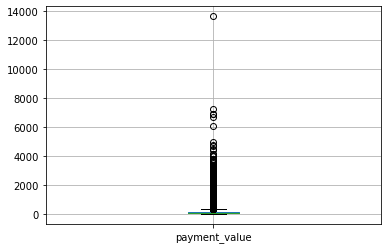

In [9]:
df.boxplot("payment_value")

In [10]:
distance_IQ(df["payment_value"])

Element 0 bellow Q1 - 1.5 * IQ (-111.25)
Element 7504 above Q3 + 1.5 * IQ (345.68)


In [11]:
df = df[df["payment_value"] < 345]

<AxesSubplot:>

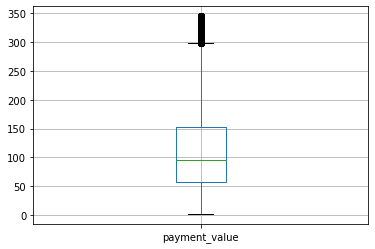

In [12]:
#Après nettoyage
df.boxplot("payment_value")

## Jours d'attentes

In [13]:
#Création de la variable jour d'attente
delay = df['order_delivered_customer_date'] - df['order_purchase_timestamp']
delay = delay.round("D").dt.days
df = pd.concat([df, delay], axis = 1)
df = df.rename(columns={0: "delay"})
df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_purchase_timestamp,order_delivered_customer_date,price,freight_proportion_price,payment_installments,payment_value,boleto,credit_card,debit_card,not_defined,voucher,weight,quantity,review_score,delay
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,2017-05-25 10:35:35,124.99,0.175054,2.0,146.87,0.0,1.0,0.0,0.0,0.0,8683.0,1.0,4.0,9
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,2018-01-29 12:41:19,289.00,0.160830,8.0,335.48,0.0,1.0,0.0,0.0,0.0,10150.0,1.0,5.0,17
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,2018-06-14 17:58:51,139.94,0.127126,7.0,157.73,0.0,1.0,0.0,0.0,0.0,8267.0,1.0,5.0,26
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,2018-03-28 16:04:25,149.94,0.155796,1.0,173.30,0.0,1.0,0.0,0.0,0.0,12160.0,1.0,5.0,15
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,2018-08-09 20:55:48,230.00,0.096739,8.0,252.25,0.0,1.0,0.0,0.0,0.0,5200.0,1.0,5.0,11


## Nombre de jours de différence entre le dernier achats et le reste

In [14]:
#Nombre de jour entre les achats et aujourd'hui
days_raw = compare_time(df['order_purchase_timestamp']).dt.days
#Nombre de jour entre le dernier achat et le reste
days_raw = pd.DataFrame(days_raw).rename(columns={"order_purchase_timestamp": "days_since_last_command"})
days = days_raw - days_raw.min()
df = pd.concat([df, days], axis = 1)
df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_purchase_timestamp,order_delivered_customer_date,price,freight_proportion_price,payment_installments,payment_value,boleto,credit_card,debit_card,not_defined,voucher,weight,quantity,review_score,delay,days_since_last_command
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,2017-05-25 10:35:35,124.99,0.175054,2.0,146.87,0.0,1.0,0.0,0.0,0.0,8683.0,1.0,4.0,9,470
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,2018-01-29 12:41:19,289.00,0.160830,8.0,335.48,0.0,1.0,0.0,0.0,0.0,10150.0,1.0,5.0,17,229
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,2018-06-14 17:58:51,139.94,0.127126,7.0,157.73,0.0,1.0,0.0,0.0,0.0,8267.0,1.0,5.0,26,102
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,2018-03-28 16:04:25,149.94,0.155796,1.0,173.30,0.0,1.0,0.0,0.0,0.0,12160.0,1.0,5.0,15,169
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,2018-08-09 20:55:48,230.00,0.096739,8.0,252.25,0.0,1.0,0.0,0.0,0.0,5200.0,1.0,5.0,11,32


## Date la plus récente et ancienne

In [15]:
print("Temps entre l'achat le plus ancien et récent: {0} jours".format(df["days_since_last_command"].max()))
print("{0} - {1}".format(df["order_purchase_timestamp"].min(), df["order_purchase_timestamp"].max()))

Temps entre l'achat le plus ancien et récent: 696 jours
2016-10-03 09:44:50 - 2018-08-29 15:00:37


# Analyse univariée

## Derniers achats

<AxesSubplot:xlabel='days_since_last_command', ylabel='Count'>

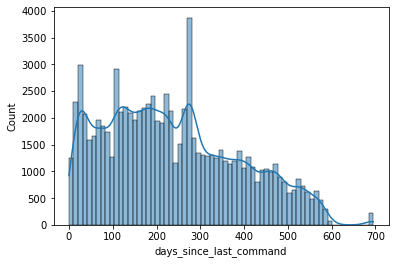

In [16]:
tmp = df[["customer_unique_id", 'days_since_last_command']].groupby(by = "customer_unique_id").min()
sns.histplot(data=tmp, x="days_since_last_command", kde=True)

<AxesSubplot:>

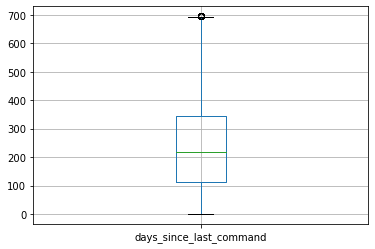

In [17]:
tmp.boxplot()

In [18]:
tmp.describe()

,days_since_last_command
count,86155.000000
mean,237.724752
std,152.348063
min,0.000000
25%,114.000000
50%,219.000000
75%,346.000000
max,695.000000


Les commandes peuvent être divisées en 4 parties  de 110 jours. 

## Délais d'envoie

<AxesSubplot:xlabel='delay', ylabel='Count'>

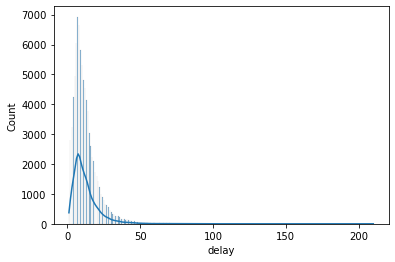

In [19]:
sns.histplot(data=df, x="delay", kde=True)

In [20]:
df["delay"].describe()

count    88949.000000
mean        12.370898
std          9.378841
min          1.000000
25%          7.000000
50%         10.000000
75%         15.000000
max        210.000000
Name: delay, dtype: float64

3/4 des produits ont un délais de livraison inférieur à 2 semaines

# Quantité d'objets par commande

<AxesSubplot:xlabel='quantity', ylabel='Count'>

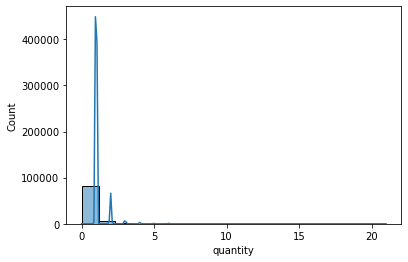

In [21]:
sns.histplot(data=df, x="quantity", kde=True)

In [22]:
df["quantity"].describe()

count    88949.000000
mean         1.115977
std          0.438378
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         21.000000
Name: quantity, dtype: float64

In [23]:
#Proportion de commandes avec plus de 1 produits
tot = df["quantity"].count()
number = df[df["quantity"] > 1.0].shape[0]
print("{0:.2f} % des commandes comportent plus de 1 produit".format(number/tot*100.0))

8.92 % des commandes comportent plus de 1 produit


# Prix des paniers

<AxesSubplot:xlabel='price', ylabel='Count'>

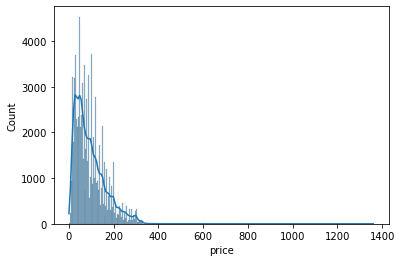

In [24]:
sns.histplot(data=df, x="price", kde=True)

In [25]:
df["price"].describe()

count    88949.000000
mean        95.076948
std         68.260297
min          0.850000
25%         43.000000
50%         79.000000
75%        129.900000
max       1360.020000
Name: price, dtype: float64

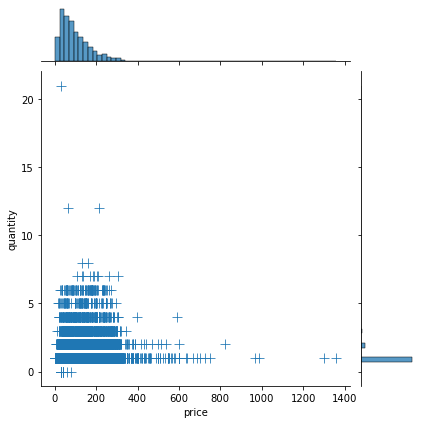

In [26]:
scatter_plot(df, "price", "quantity", "")

## Moyen de paiements

In [27]:
df[["boleto", "credit_card", "debit_card", "not_defined", "voucher"]].sum()

boleto         17967.000000
credit_card    66958.690489
debit_card      1404.500000
not_defined        0.000000
voucher         2618.809511
dtype: float64

La catégorie **not_defined** ne contient aucun élément

In [28]:
df = df.drop(['not_defined'], axis=1)

In [29]:
val = df[["boleto", "credit_card", "debit_card", "voucher"]].sum().to_numpy()
labels = df[["boleto", "credit_card", "debit_card", "voucher"]].sum().index


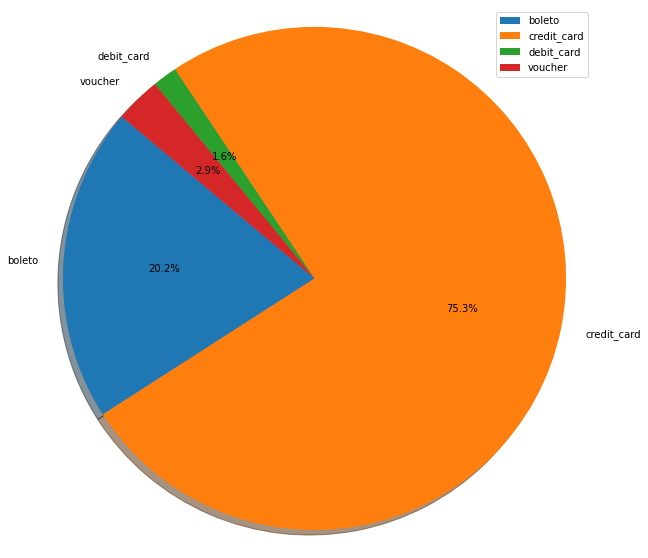

In [30]:
f, ax = plt.subplots(figsize=(10, 10))
plt.pie(val, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.legend(labels, loc="best")
plt.show()

### fusion des colonnes voucher et debit card

C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='voucher', ylabel='Density'>

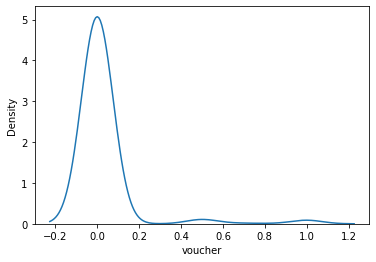

In [31]:
sns.kdeplot(df["voucher"], bw=0.5)

la valeur 0.5 coresspond à des paiements mixtes

C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='debit_card', ylabel='Density'>

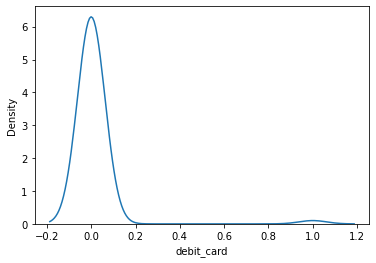

In [32]:
sns.kdeplot(df["debit_card"], bw=0.5)

In [33]:
df = df.rename(columns={"voucher": "voucher_debit_card"})
df.loc[df['debit_card'] > 0, "voucher_debit_card"] = 1.0
df = df.drop(["debit_card"], axis = 1)

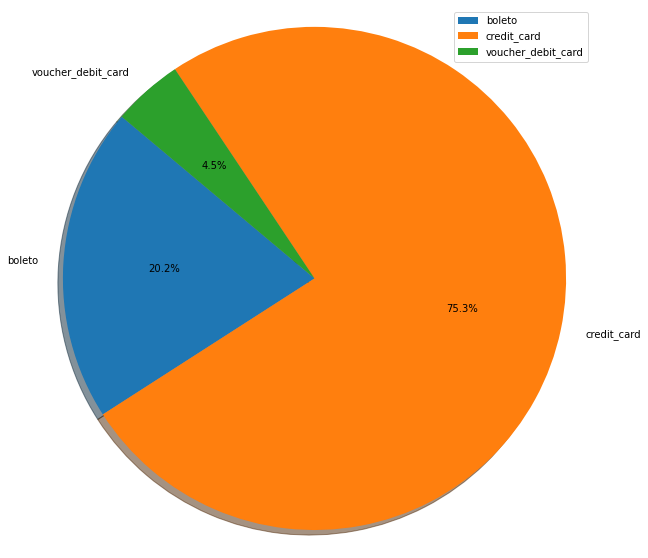

In [34]:
val = df[["boleto", "credit_card", "voucher_debit_card"]].sum().to_numpy()
labels = df[["boleto", "credit_card", "voucher_debit_card"]].sum().index

f, ax = plt.subplots(figsize=(10, 10))
plt.pie(val, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.legend(labels, loc="best")
plt.show()

# Poids (g) des commandes

<AxesSubplot:xlabel='weight', ylabel='Count'>

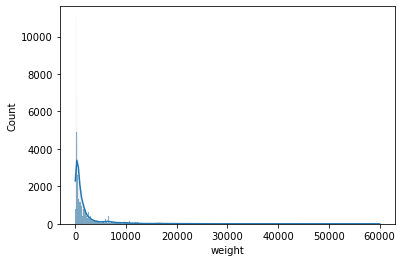

In [35]:
sns.histplot(data=df, x="weight", kde=True)

In [36]:
df["weight"].describe()

count    88949.000000
mean      1915.584560
std       3312.330855
min          0.000000
25%        300.000000
50%        700.000000
75%       1800.000000
max      60000.000000
Name: weight, dtype: float64

In [37]:
df[df["weight"] == 60000]

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_purchase_timestamp,order_delivered_customer_date,price,freight_proportion_price,payment_installments,payment_value,boleto,credit_card,voucher_debit_card,weight,quantity,review_score,delay,days_since_last_command
63325,8d00bb042dfdfc4c8121bcd01fbc78bc,d4fda150c67fa99a9927ca5fe66dc310,11900,registro,SP,6d34c087b843ae0fdb296f15d948e45f,2018-06-20 19:11:56,2018-06-29 17:21:38,471.8,0.086329,1.0,138.315,0.0,0.0,1.0,60000.0,2.0,5.0,9,70


# % des frais de port sur le prix du produit

<AxesSubplot:xlabel='freight_proportion_price', ylabel='Count'>

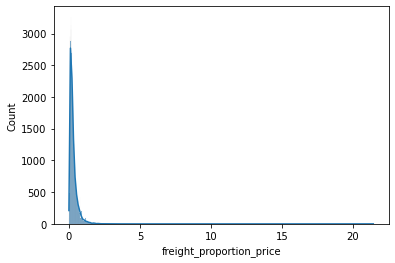

In [38]:
sns.histplot(data=df, x="freight_proportion_price", kde=True)

In [39]:
df["freight_proportion_price"].describe()

count    88949.000000
mean         0.305899
std          0.303705
min          0.000000
25%          0.134928
50%          0.222318
75%          0.372675
max         21.447059
Name: freight_proportion_price, dtype: float64

1/4 des produits ont des frais de prots qui sont supérieur à 30 % du prix de la commande. Certains produits ont la velur de leur frais de port supérieur au prix du produit.

# Echellonage des paiements 

<AxesSubplot:xlabel='payment_installments', ylabel='Count'>

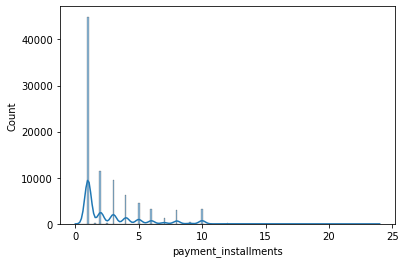

In [40]:
sns.histplot(data=df, x="payment_installments", kde=True)

In [41]:
df["payment_installments"].describe()

count    88949.000000
mean         2.688556
std          2.467686
min          0.000000
25%          1.000000
50%          1.000000
75%          4.000000
max         24.000000
Name: payment_installments, dtype: float64

In [42]:
#des achats ont un échellonage de 0, on les  met à 1.
ind = df["payment_installments"] == 0
df.loc[ind, ["payment_installments"]] = 1

# Clients réguliers

In [43]:
#regular customers (more than 1 order)
id_counts  = df["customer_unique_id"].value_counts()
regular = len(id_counts[id_counts > 1])
print("{0} clients ont commandé plus d'une fois.".format(regular))
tot = len(pd.unique(df["customer_unique_id"]))
print("Cela représente {0:.2f}% des clients".format(regular/tot*100.0))

2520 clients ont commandé plus d'une fois.
Cela représente 2.92% des clients


### Data frame avec les clients réguliers.

In [44]:
lines = []
for regular_customer in id_counts[id_counts > 1].index:
    lines = np.concatenate((lines,np.where(df["customer_unique_id"] == regular_customer)[0]))
df_regular = df.iloc[lines]

### Nombre d'achat sur le site

7.82 % des clients réguliers ont commandé plus de 2 fois.


,nb connection
count,2520.000000
mean,2.108730
std,0.496997
min,2.000000
25%,2.000000
50%,2.000000
75%,2.000000
max,15.000000


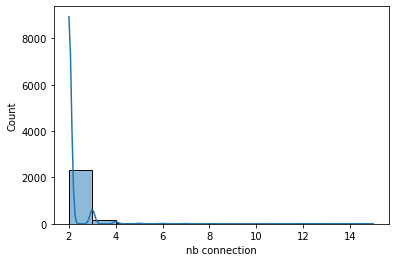

In [45]:
tmp = df_regular.groupby(by=["customer_unique_id"]).count()["customer_id"].to_numpy()
tmp = pd.DataFrame(tmp, columns = {"nb connection"})
sns.histplot(data=tmp, x="nb connection", kde=True)
#% de clients qui ont fait plus de 2 achats
print("{0:.2f} % des clients réguliers ont commandé plus de 2 fois.".format(
    len(np.where(tmp["nb connection"] > 2)[0])/tmp.shape[0] *100.0))
tmp.describe()

### Data frame avec les clients non réguliers

In [46]:
indice = np.arange(df.shape[0])
#Find the set difference of two arrays. Return the unique values in ar1 that are not in ar2.
indice = np.setdiff1d(indice, lines)
df_no_regular = df.iloc[indice]

## Dernière commande faite

In [47]:
last_regular = df_regular.groupby(by=["customer_unique_id"]).min()["days_since_last_command"].to_numpy()
last_regular = pd.DataFrame(last_regular, columns = {"days_since_last_command"})

last_non_regular = df_no_regular.groupby(by=["customer_unique_id"]).min()["days_since_last_command"].to_numpy()
last_non_regular = pd.DataFrame(last_non_regular, columns = {"days_since_last_command"})

#sns.histplot(data=last_regular, x="days_since_last_command", kde=True)

3/4 des clients réguliers ont acheté quelque chose au cours de l'année.

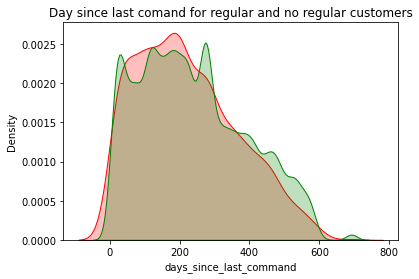

In [48]:
# Compare both distribution
fig = sns.kdeplot(last_regular['days_since_last_command'], shade=True, color="r")
fig = sns.kdeplot(last_non_regular['days_since_last_command'], shade=True, color="g")
plt.title("Day since last comand for regular and no regular customers")
plt.show()

#### Mann-Whitney rank test

La moyenne des jours écoulés depuis le dernier achat est-il ma même entre les clients réguliers et nouveaux clients ?

Hypothèse:
* H0: Les distributions sont égales
* H1: Les distributions ne sont pas égales

In [49]:
rootline_mannwhitneyu(last_regular['days_since_last_command'].to_numpy(), 
                      last_non_regular['days_since_last_command'].to_numpy())

Statistics=98875994.000, p=6.203242221040599e-08
Different distribution (reject H0)


p < 0.05: **Rejet de H0**

In [50]:
last_regular.mean()

days_since_last_command    220.488492
dtype: float64

In [51]:
last_non_regular.mean()

days_since_last_command    238.244096
dtype: float64

En moyenne la date du dernier achat est plus **ancien pour les clients non réguliers**.

# Panier moyen

In [52]:
basket_regular = df_regular.groupby(by=["customer_unique_id"]).mean()["price"].to_numpy()
basket_regular = pd.DataFrame(basket_regular, columns = {"Average basket regular"})
basket_no_regular = df_no_regular.groupby(by=["customer_unique_id"]).mean()["price"].to_numpy()
basket_no_regular = pd.DataFrame(basket_no_regular, columns = {"Average basket no regular"})

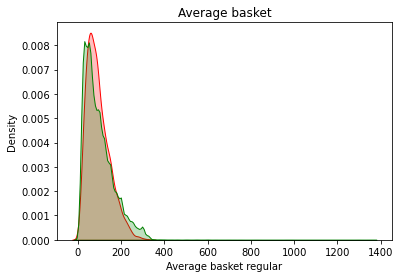

In [53]:
# Compare both distribution
fig = sns.kdeplot(basket_regular['Average basket regular'], shade=True, color="r")
fig = sns.kdeplot(basket_no_regular['Average basket no regular'], shade=True, color="g")
plt.title("Average basket")
plt.show()

#### Mann-Whitney rank test

La panier moyen d'achat est-il le même entre les deux catégorie de clients ?

Hypothèse:
* H0: Les distributions sont égales
* H1: Les distributions ne sont pas égales

In [54]:
rootline_mannwhitneyu(basket_regular['Average basket regular'].to_numpy(), 
                      basket_no_regular['Average basket no regular'].to_numpy())

Statistics=102620415.000, p=0.012433270664171464
Different distribution (reject H0)


In [55]:
basket_regular['Average basket regular'].mean()

91.67850081727133

In [56]:
basket_no_regular['Average basket no regular'].mean()

95.30561116764994

**Les clients non réguliers** ont en moyenne un panier plus important.

# Export des données nettoyées 

In [57]:
df.to_csv("clean_achat_data.csv")